<a href="https://colab.research.google.com/github/akshatdalton/Dictionary-Learning/blob/main/DictionaryLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/akshatdalton/Dictionary-Learning.git
%cd Dictionary-Learning/

In [4]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import image
# from sklearn.datasets import load_sample_image
import librosa
import IPython.display as ipd
import scipy.misc
import cv2

In [5]:
class DictionaryLearning(object):
    def __init__(self, precision=1.0e-4, max_iter=30, no_of_coefs=None):
        self.precision = precision
        self.max_iter = max_iter
        self.no_of_coefs = no_of_coefs
        self.dictionary, self.sparse_code = None, None
    
    def initialise_dictionary(self, dictionary=None, Y=None, no_of_atoms=None):
        if dictionary is not None:
            self.dictionary = dictionary
        else:
            if no_of_atoms is None:
                no_of_atoms = Y.shape[1]
            self.dictionary = Y[:, :no_of_atoms]

    def train_samples(self, Y, do_normalise=True, return_iter=False):
        iteration = 0
        while iteration < self.max_iter:
            iteration += 1
            if do_normalise:
                normalize(self.dictionary, axis=0, copy=False)
            self.sparse_code = self.find_sparse_representation(Y)
            if self.sparse_code.ndim == 1:
                self.sparse_code = self.sparse_code.reshape((-1, 1))
            # Frobenius norm
            error = LA.norm(Y - (self.dictionary @ self.sparse_code))
            if (error <= self.precision).all():
                break

            self.update_dictionary(Y)
        
        if return_iter:
            return iteration
    
    def update_dictionary(self, Y):
        """This method must be overridden by the subclass.
        """
        raise NotImplementedError("`update_dictionary` method needs to be overridden")

    def find_sparse_representation(self, Y):
        return linear_model.orthogonal_mp(self.dictionary, Y, n_nonzero_coefs=self.no_of_coefs, precompute=True)

In [4]:
class MOD(DictionaryLearning):
    def update_dictionary(self, Y):
        self.dictionary = Y @ LA.pinv(self.sparse_code)

phi = np.array([[1, 0, 1, 0, 0, 1],
                [0, 1, 1, 1, 0, 0],
                [1, 0, 0, 1, 1, 0],
                [0, 1, 0, 0, 1, 1]])

phi = phi.astype("float")
# Y = np.random.rand(4, 10) * 100
Y = np.array([[0],
              [2],
              [3],
              [5]])

model = MOD(max_iter=100, no_of_coefs=1)
model.initialise_dictionary(phi)
model.train_samples(Y, return_iter=True)

2

In [6]:
print(model.dictionary @ model.sparse_code)
print(model.dictionary)
print(model.sparse_code)

[[0.]
 [2.]
 [3.]
 [5.]]
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.32444284 0.        ]
 [0.         0.         0.         0.         0.48666426 0.        ]
 [0.         0.         0.         0.         0.81110711 0.        ]]
[[0.      ]
 [0.      ]
 [0.      ]
 [0.      ]
 [6.164414]
 [0.      ]]


In [ ]:
class MaximumLikelihood(DictionaryLearning):
    def update_dictionary(self, Y, eta=0.01):
        self.dictionary = self.dictionary + \
                          eta * (Y - self.dictionary @ self.sparse_code) @ self.sparse_code.T

phi = np.array([[1, 0, 1, 0, 0, 1],
                [0, 1, 1, 1, 0, 0],
                [1, 0, 0, 1, 1, 0],
                [0, 1, 0, 0, 1, 1]])

phi = phi.astype("float")
# Y = np.random.rand(4, 10) * 100
Y = np.array([[0],
              [1],
              [2],
              [3]])

model = MaximumLikelihood(max_iter=10000, no_of_coefs=1)
model.initialise_dictionary(phi)
model.train_samples(Y, return_iter=True)

64

In [ ]:
print(model.dictionary @ model.sparse_code)
print(model.dictionary)
print(model.sparse_code)

[[0.        ]
 [0.99992455]
 [2.00006036]
 [2.99998491]]
[[0.70710678 0.         0.70710678 0.         0.         0.70710678]
 [0.         0.70710678 0.70710678 0.70710678 0.26724108 0.        ]
 [0.70710678 0.         0.         0.70710678 0.53453862 0.        ]
 [0.         0.70710678 0.         0.         0.80177969 0.70710678]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [3.74165739]
 [0.        ]]


In [ ]:
class MAP(DictionaryLearning):
    def update_dictionary(self, Y, eta=0.1):
        error = Y - self.dictionary @ self.sparse_code
        self.dictionary = self.dictionary + \
                          eta * error @ self.sparse_code.T + \
                          eta * np.trace(self.sparse_code @ error.T @ self.dictionary) * self.dictionary

phi = np.array([[1, 0, 1, 0, 0, 1],
                [0, 1, 1, 1, 0, 0],
                [1, 0, 0, 1, 1, 0],
                [0, 1, 0, 0, 1, 1]])

phi = phi.astype("float")
# Y = np.random.rand(4, 10) * 100
Y = np.array([[0],
              [1],
              [2],
              [3]])

model = MAP(max_iter=10000, no_of_coefs=1)
model.initialise_dictionary(phi)
model.train_samples(Y, return_iter=True)

11

In [ ]:
print(model.dictionary @ model.sparse_code)
print(model.dictionary)
print(model.sparse_code)

[[0.        ]
 [0.99994485]
 [2.00004412]
 [2.99998897]]
[[0.70710678 0.         0.70710678 0.         0.         0.70710678]
 [0.         0.70710678 0.70710678 0.70710678 0.2672465  0.        ]
 [0.70710678 0.         0.         0.70710678 0.53453428 0.        ]
 [0.         0.70710678 0.         0.         0.80178078 0.70710678]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [3.74165739]
 [0.        ]]


In [5]:
class KSVD(DictionaryLearning):
    def update_dictionary(self, Y):
        # Less than this threshold will be considered as zero.
        threshold = 1.0e-3
        for k in range(self.dictionary.shape[1]):
            W = np.where(self.sparse_code[k] >= threshold)[0]
            if len(W) == 0:
                continue
            
            self.dictionary[:, k] = 0
            error_r = (Y - self.dictionary @ self.sparse_code)[:, W]
            
            U, delta, VT = LA.svd(error_r, full_matrices=False)

            self.dictionary[:, k] = U[:, 0]
            self.sparse_code[k, W] = VT[0, :] * delta[0]


phi = np.array([[1, 0, 1, 0, 0, 1],
                [0, 1, 1, 1, 0, 0],
                [1, 0, 0, 1, 1, 0],
                [0, 1, 0, 0, 1, 1]], dtype="float")

# Y = np.random.rand(4, 10) * 100
# Y = np.array([[0, 1, 1, 0, 0, 0, 2],
#               [2, 5, 0, 1, 0, 0, 2],
#               [3, 0, 0, 0, 1, 0, 2],
#               [5, 2, 0, 0, 0, 1, 2]])
Y = np.array([[0],
              [2],
              [3],
              [5]])

model = KSVD(max_iter=10000, no_of_coefs=1)
model.initialise_dictionary(phi)
model.train_samples(Y, do_normalise=False, return_iter=True)

3

In [ ]:
print(model.dictionary @ model.sparse_code)
print(model.dictionary)
print(model.sparse_code)

[[0.]
 [2.]
 [3.]
 [5.]]
[[1.         0.         1.         0.         0.         1.        ]
 [0.         0.32444284 1.         1.         0.32444284 0.        ]
 [1.         0.48666426 0.         1.         0.48666426 0.        ]
 [0.         0.81110711 0.         0.         0.81110711 1.        ]]
[[0.      ]
 [6.164414]
 [0.      ]
 [0.      ]
 [0.      ]
 [0.      ]]


Text(0.5, 1.0, 'Dictionary atoms')

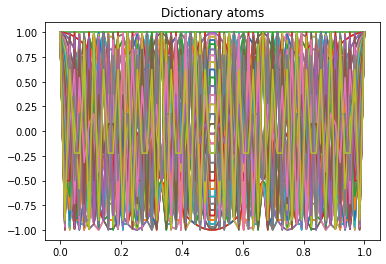

In [ ]:
npts = 64
domain = np.linspace(0, 1, npts)

# generate a dictionary and manufactured solution
X = np.array([np.cos(2 * np.pi * m * domain) for m in range(1, 100)]).T

plt.figure()
plt.plot(domain, X)
plt.title('Dictionary atoms')

In [ ]:
model = KSVD(max_iter=10000, no_of_coefs=2)
model.initialise_dictionary(Y=X, no_of_atoms=80)
model.train_samples(X, do_normalise=False, return_iter=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


1

In [ ]:
test = 2 * np.array([np.cos(2 * np.pi * 1 * domain)]) + 3 * np.array([np.cos(2 * np.pi * 2 * domain)])
test = test.reshape(-1, 1)
model.find_sparse_representation(test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

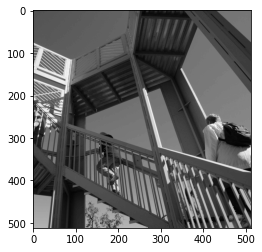

In [6]:
im_ascent = scipy.misc.ascent().astype(np.float)
im_ascent = cv2.resize(im_ascent, (512, 512))
plt.imshow(im_ascent, cmap="gray")

In [ ]:
patches = image.extract_patches_2d(im_ascent, (256, 256))
plt.imshow(patches[55], cmap="gray")

In [ ]:

model = KSVD(max_iter=10000, no_of_coefs=2)
model.initialise_dictionary(phi)
model.train_samples(im_ascent, do_normalise=False, return_iter=True)

In [ ]:
noise = np.random.randint(2, size=np.product(im_ascent.shape)).reshape(im_ascent.shape)
noisy_img = im_ascent * noise

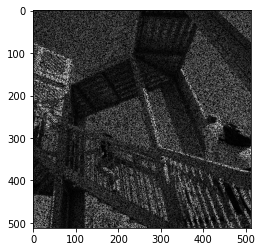

In [ ]:
plt.imshow(noisy_img, cmap="gray")

In [ ]:
img_col = im_ascent.reshape(64, np.product(im_ascent.shape) // 64)

In [ ]:
model = KSVD(precision=1, max_iter=500, no_of_coefs=10)
model.initialise_dictionary(Y=img_col, no_of_atoms=150)
model.train_samples(img_col, do_normalise=False, return_iter=True)

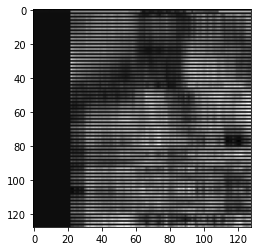

In [ ]:
plt.imshow((model.dictionary @ model.sparse_code).reshape(128, 128), cmap="gray")